In [59]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8

from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

# Helper Functions

In [60]:
def missing_values(data,n):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(
        ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(n)

def test_train(train, test):
    train['source']= 'train'
    test['source'] = 'test'
    data=pd.concat([train, test],ignore_index=True)
    print(data.shape)
    return data

def get_column_type(data):
    obj = []
    int_cont = []
    for name in data.columns:
        if data[name].dtype is np.dtype( 'O') and name != 'source':
            obj.append(name)
        else:
            int_cont.append(name)
    return obj, int_cont

def dummy_data(data, todummy_list):
    for x in todummy_list:
        dummies = pd.get_dummies(data[x], prefix=x, dummy_na=False)
        data = data.drop(x,1)
        data = pd.concat([data, dummies], axis=1)
    return data

zoneToStateMapping = {'SW':['lagos', 'oyo', 'ekiti', 'ogun', 'ondo', 'osun'],
                      'SS':['akwa ibom', 'bayelsa', 'cross river', 'rivers', 'delta', 'edo'],
                     'SE':['abia','anambra','ebonyi', 'enugu', 'imo'],
                     'NW':['jigawa','kaduna','kano','katsina','kebbi','sokoto','zamfara'],
                     'NE':['adamawa','bauchi','borno','gombe','yobe','taraba'],
                     'NC':['benue','kogi','kwara','nassarawa','niger','plateau','fct']}

def groupByZone(state):
    state = state.lower()
    for zone in zoneToStateMapping:
        if state in zoneToStateMapping[zone]:
            return zone
        else:continue

def plot_correlation_matrix(data, columns):
    colormap = plt.cm.RdBu
    plt.figure(figsize=(14,12))
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    sns.heatmap(data[columns].astype(float).corr(),linewidths=0.1,vmax=1.0,
                square=True, cmap=colormap, linecolor='white', annot=True)

def changeTargetTypeToInt(value):
    return int(value)

def getIntegerFromStringValue(value):
    if len(value)>3:
        return 6
    else:
        return value

# Get data

In [61]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
data = test_train(train, test)

(54808, 20)


In [62]:
data.head(2)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,State_Of_Origin,Targets_met,Training_score_average,Trainings_Attended,Year_of_birth,Year_of_recruitment,source
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",ANAMBRA,1,41,2,1986,2011,train
1,Agency and others,Customer Support and Field Operations,YAK/S/00002,Yes,Male,12.5,Married,0,No,0,No,0.0,First Degree or HND,ANAMBRA,0,52,2,1991,2015,train


In [63]:
missing_values(data,3)

,Total,Percent
Promoted_or_Not,16496,30.097796
Qualification,2409,4.395344
source,0,0.000000


In [64]:
train.Past_Disciplinary_Action.value_counts()

No     38161
Yes      151
Name: Past_Disciplinary_Action, dtype: int64

In [65]:
data.columns

Index(['Channel_of_Recruitment', 'Division', 'EmployeeNo', 'Foreign_schooled',
       'Gender', 'Last_performance_score', 'Marital_Status',
       'No_of_previous_employers', 'Past_Disciplinary_Action',
       'Previous_Award', 'Previous_IntraDepartmental_Movement',
       'Promoted_or_Not', 'Qualification', 'State_Of_Origin', 'Targets_met',
       'Training_score_average', 'Trainings_Attended', 'Year_of_birth',
       'Year_of_recruitment', 'source'],
      dtype='object')

In [71]:
categorical =['Channel_of_Recruitment','Division','Foreign_schooled','Gender','Marital_Status',
              'Previous_Award','Previous_IntraDepartmental_Movement','Qualification',
              'Past_Disciplinary_Action','zone']

In [72]:
Numerical = ['Last_performance_score','No_of_previous_employers','Targets_met',
             'Training_score_average','Trainings_Attended','Age_recurited','Years_in_company']

In [68]:
data['Age_recurited'] = data.Year_of_recruitment - data.Year_of_birth
data['Years_in_company'] = 2019 - data.Year_of_recruitment
data['Qualification'] = data['Qualification'].fillna(value='something_here')
data['zone'] = data.State_Of_Origin.apply(lambda x: groupByZone(x))
data['No_of_previous_employers'] = data.No_of_previous_employers.apply(lambda x: getIntegerFromStringValue(x))
data.drop(['Year_of_recruitment','Year_of_birth','State_Of_Origin'], 1,inplace=True)
data['Previous_Award'] = data['Previous_Award'].astype(str)

In [69]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",1,41,2,train,25,8,SE


In [70]:
for c in ['Age_recurited', 'Years_in_company', 'Training_score_average']:
    data[c] = np.log1p(data[c])

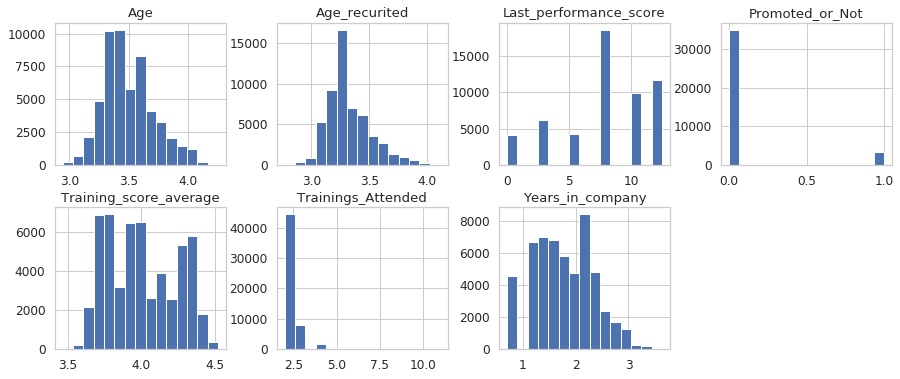

In [13]:

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

data[continous].hist(bins=15, figsize=(15, 6), layout=(2, 4));

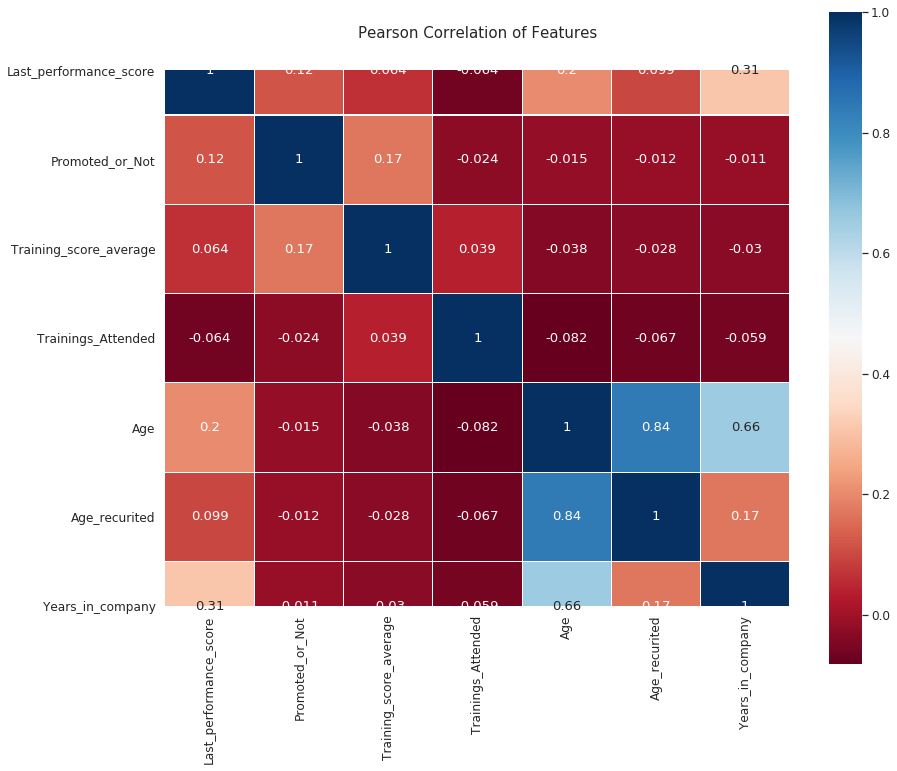

In [14]:
plot_correlation_matrix(data, continous_corr)

What affects promotion most is the Last Performance Score and Training Score average,
this can be seen in the correlation matrix above.

In [14]:
data.head(1)

,Channel_of_Recruitment,Division,EmployeeNo,Foreign_schooled,Gender,Last_performance_score,Marital_Status,No_of_previous_employers,Past_Disciplinary_Action,Previous_Award,Previous_IntraDepartmental_Movement,Promoted_or_Not,Qualification,Targets_met,Training_score_average,Trainings_Attended,source,Age_recurited,Years_in_company,zone
0,Direct Internal process,Commercial Sales and Marketing,YAK/S/00001,No,Female,12.5,Married,0,No,0,No,0.0,"MSc, MBA and PhD",1,3.73767,2,train,3.258097,2.197225,SE


In [73]:
to_dummy = [ i for i in categorical if i not in ['EmployeeNo']]
data = dummy_data(data, to_dummy)

In [53]:
data.shape

(54808, 76)

In [74]:
train = data.loc[data['source']=='train']
train['Promoted_or_Not'] = train['Promoted_or_Not'].apply(lambda value: changeTargetTypeToInt(value))
test = data.loc[data['source']=='test']
train.drop('source',axis=1,inplace=True)
test.drop(['source','Promoted_or_Not'],axis=1,inplace=True)

# Data Splitting

In [57]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Promoted_or_Not'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Promoted_or_Not'], cv=cv_folds, scoring='f1_micro')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Promoted_or_Not'].values, dtrain_predictions))
    print("F1 (Train): %f" % metrics.f1_score(dtrain['Promoted_or_Not'], dtrain_predictions, average='micro'))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),
                                                                                 np.min(cv_score),np.max(cv_score)))
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 40, 12
         
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')



Model Report
Accuracy : 0.9408
F1 (Train): 0.940802
CV Score : Mean - 0.9398361 | Std - 0.001175745 | Min - 0.9382668 | Max - 0.9419212


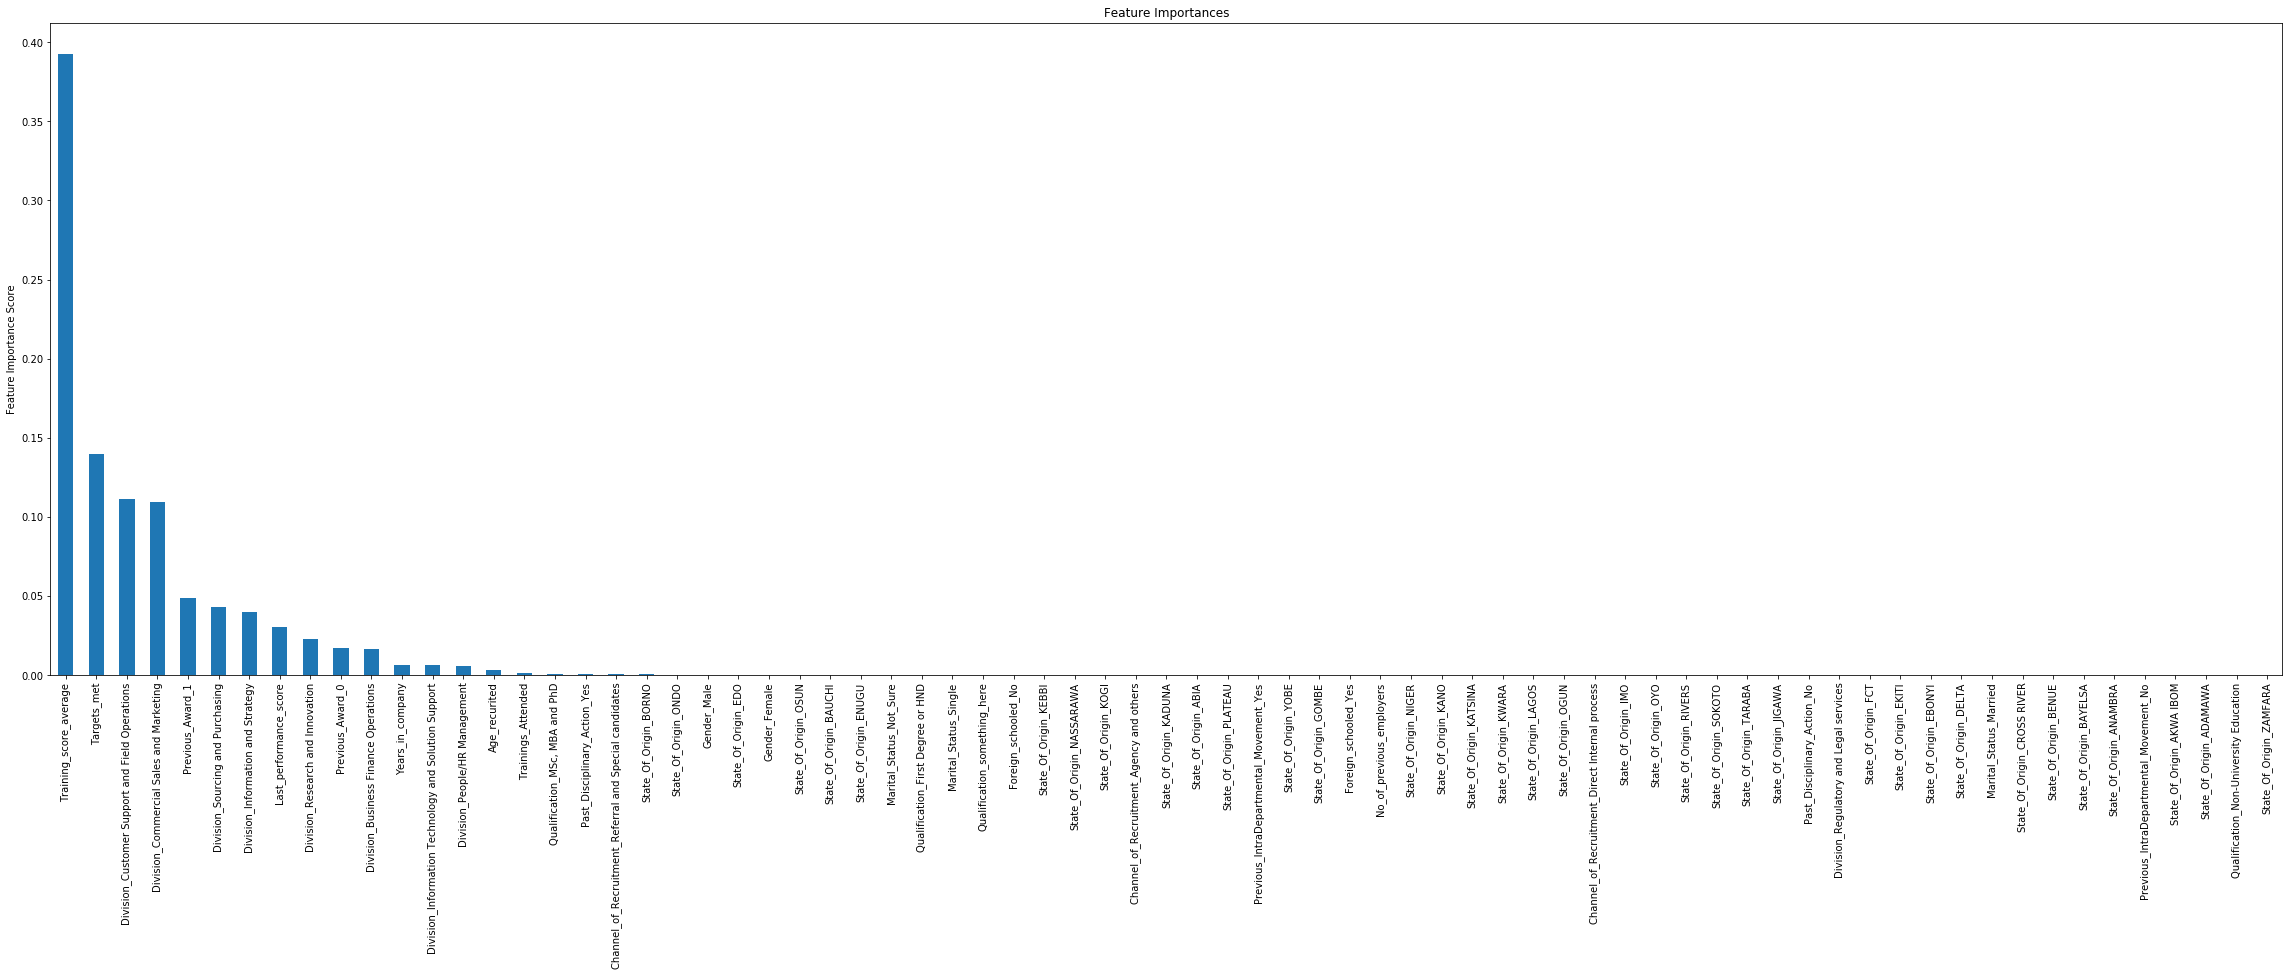

In [58]:
IDcol = 'EmployeeNo'
target = 'Promoted_or_Not'
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

In [137]:
param_test1 = {'n_estimators':range(160,241,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=400,
                                  min_samples_leaf=40,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=8,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=40,
                                                  min_samples_split=400,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  pre

In [138]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 190}, 0.9408017783176362)

In [20]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  presor

In [23]:
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 9, 'min_samples_split': 1000}, 0.9414021233220474)

In [29]:
param_test3 = {'min_samples_leaf':range(1,32,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9,
                                                    max_features='sqrt', subsample=0.8, random_state=10,min_samples_split=1800),
                       param_grid = param_test3, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  pre

In [30]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 11}, 0.9415326579835199)


Model Report
Accuracy : 0.9445
F1 (Train): 0.944534
CV Score : Mean - 0.9415327 | Std - 0.001712382 | Min - 0.9383973 | Max - 0.9434873


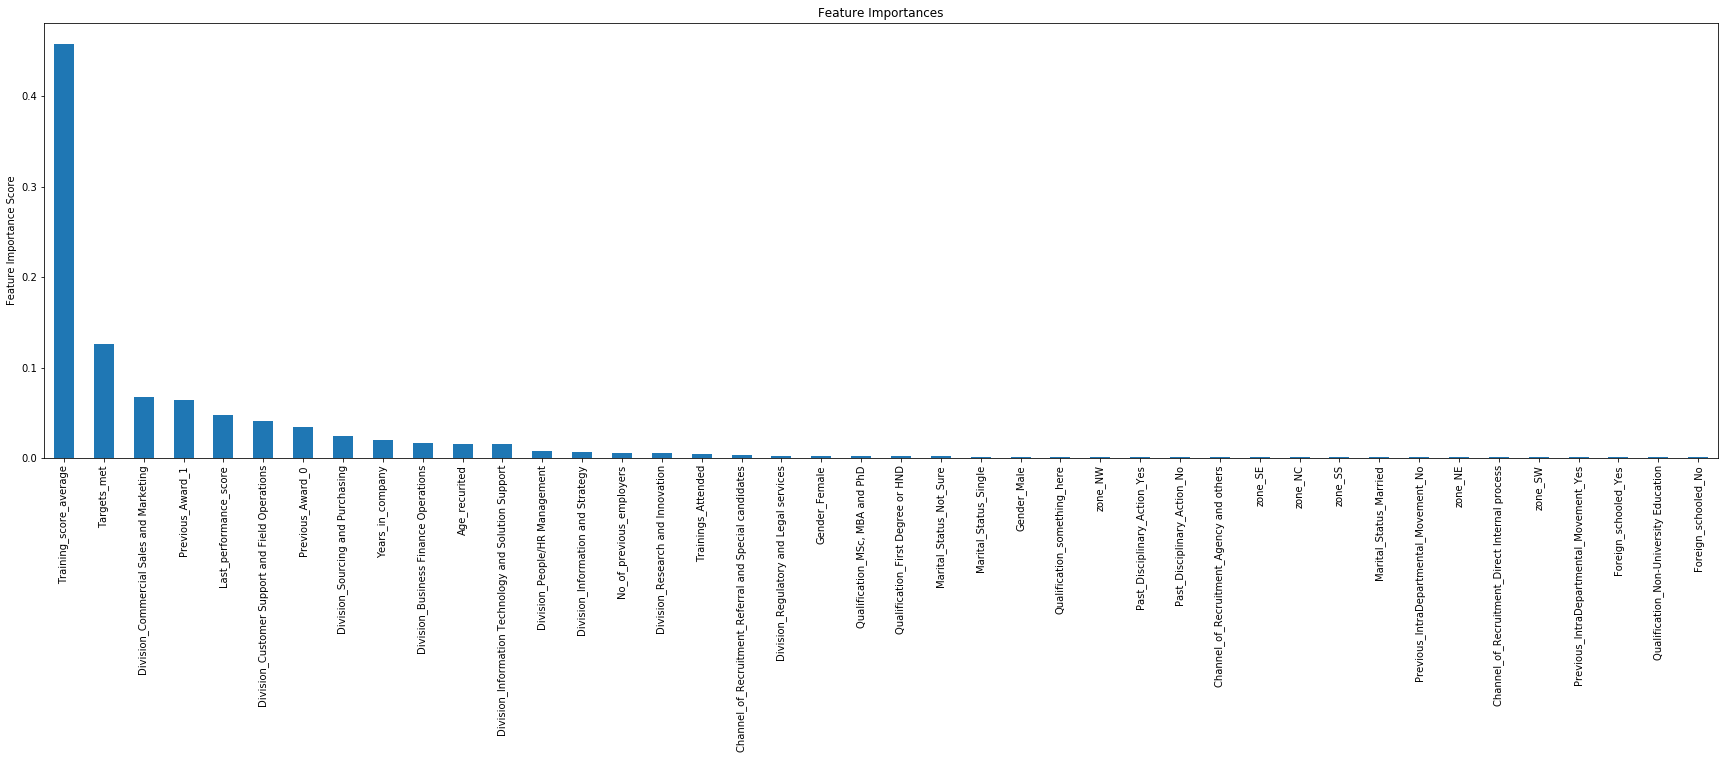

In [31]:
modelfit(gsearch3.best_estimator_, train, predictors)

In [32]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, 
                            min_samples_split=1800, min_samples_leaf=11, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=11,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  pres

In [33]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 17}, 0.9423678809121718)

In [34]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, 
                            min_samples_split=1800, min_samples_leaf=11, random_state=10, max_features=17),
                       param_grid = param_test5, scoring='f1_micro',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=9,
                                                  max_features=17,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=11,
                                                  min_samples_split=1800,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=190,
                                                  n_iter_no_change=None,
                                                  presor

In [35]:
gsearch5.best_params_, gsearch5.best_score_

({'subsample': 0.8}, 0.9423678809121718)


Model Report
Accuracy : 0.9454
F1 (Train): 0.945448
CV Score : Mean - 0.9423679 | Std - 0.001584239 | Min - 0.940094 | Max - 0.9447925


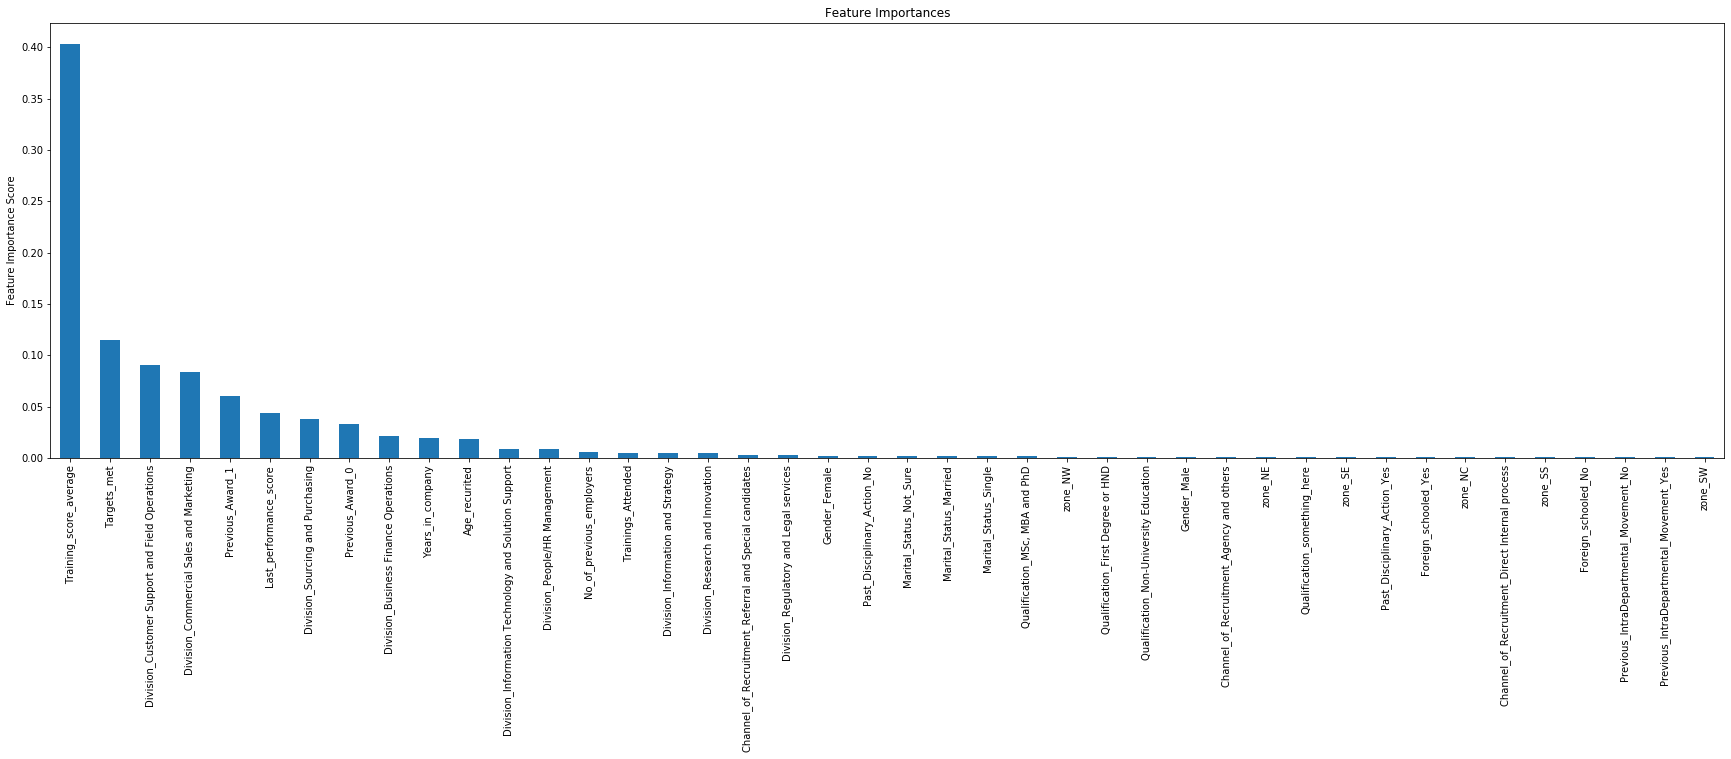

In [36]:
modelfit(gsearch5.best_estimator_, train, predictors)


Model Report
Accuracy : 0.9454
F1 (Train): 0.945448
CV Score : Mean - 0.9423679 | Std - 0.001584239 | Min - 0.940094 | Max - 0.9447925


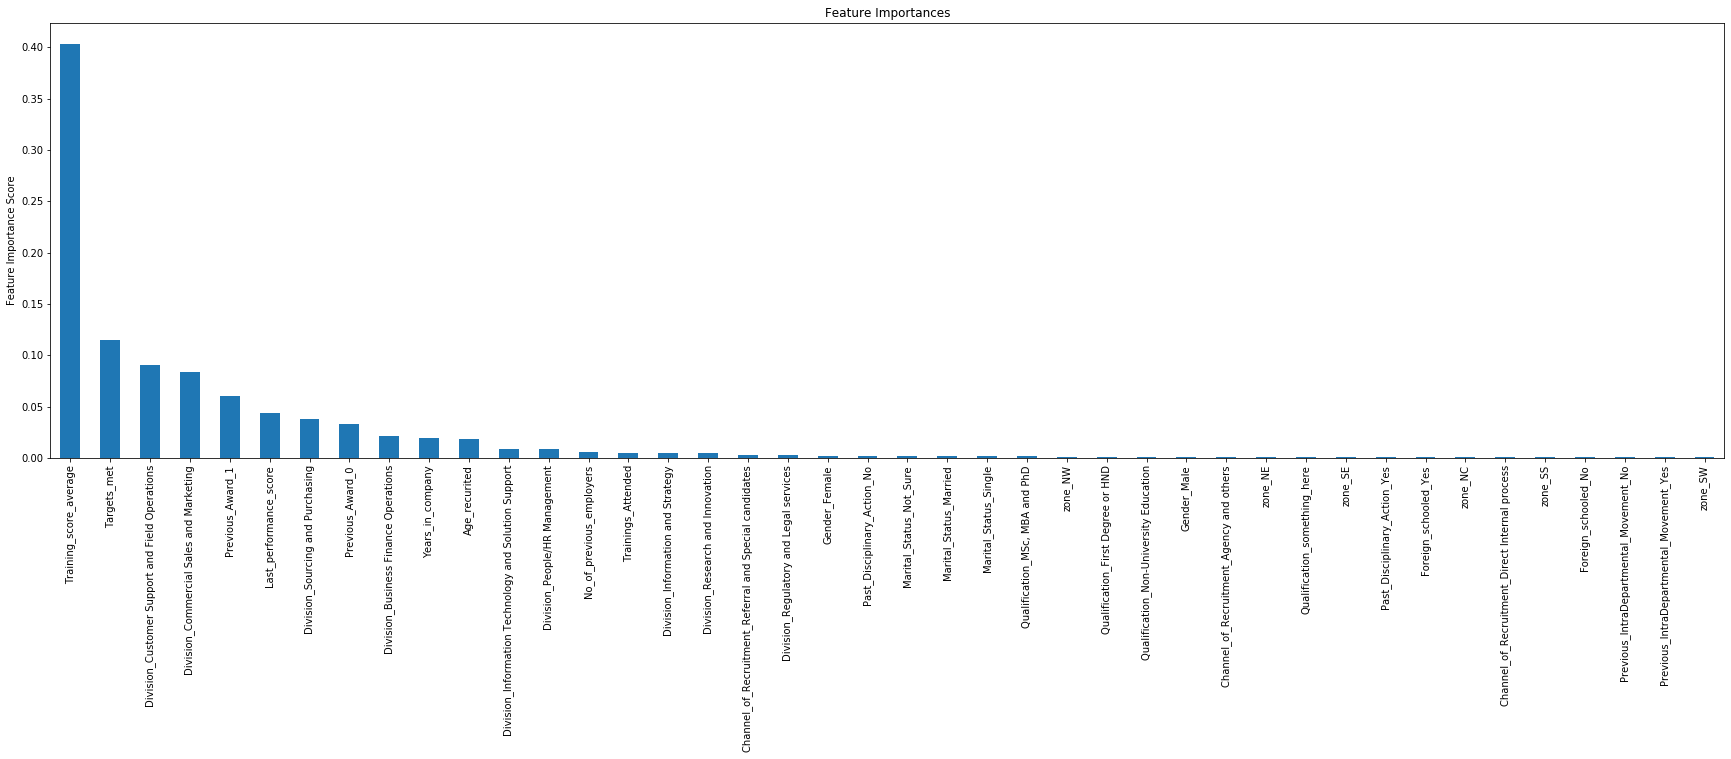

In [20]:
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=190,max_depth=9, min_samples_split=1800, 
                                         min_samples_leaf=11, subsample=0.8, random_state=10, max_features=17)
modelfit(gbm_tuned_1, train, predictors)

In [22]:
submission = pd.DataFrame()
submission['EmployeeNo'] = test['EmployeeNo']
submission['Promoted_or_Not'] = gbm_tuned_1.predict(test[predictors])

In [24]:
submission.to_csv('gbmSubmission.csv', index=False)

In [77]:
from xgboost.sklearn import XGBClassifier

def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Promoted_or_Not'],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Promoted_or_Not'].values, dtrain_predictions))
    print("F1-Score (Train): %f" % metrics.f1_score(dtrain['Promoted_or_Not'], dtrain_predictions))
    
    from matplotlib.pylab import rcParams
    rcParams['figure.figsize'] = 30, 10
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

ModuleNotFoundError: No module named 'xgboost'

In [76]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27)
modelfit(xgb1, train, predictors)

NameError: name 'XGBClassifier' is not defined

##### TRY OUT XGBOOST, LGBM, CATBOOST, CNN AND NEURALNETS. ALSO NOTE: THE F1-MICRO IS THE SAME AS ACCURACY. 
##### The reason why I had to take a break was because of the weak internet connection experienced when installing XGBOOST.
##### At the moment we have a minimum of 0.9431 on Kaggle!!! Way to go!!!

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing


Y = train['Promoted_or_Not']
X = train[predictors]
# X = preprocessing.scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20)


In [29]:
clfs = [ExtraTreesClassifier(),
    RandomForestClassifier()]
clfName = {1:'Extra Trees', 2:'Random Forests'}

for i in range(len(clfs)):
    scores = cross_val_score(clfs[i], X_train, Y_train.ravel(), cv=5, scoring = 'f1_micro')
    print ("mean validation F1 for",clfName[i+1], ":", 
           "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    clf = clfs[i].fit(X_train, Y_train.ravel())
    Y_pred = clf.predict(X_test)
    f1 = f1_score(Y_test, Y_pred,average='micro')
    print ('Test F1 for',clfName[i+1], ":", f1)

mean validation F1 for Extra Trees : Accuracy: 0.92 (+/- 0.00)
Test F1 for Extra Trees : 0.9220931749967376
mean validation F1 for Random Forests : Accuracy: 0.93 (+/- 0.01)
Test F1 for Random Forests : 0.9326634477358737


Text(0, 0.5, 'Feature Importance Score')

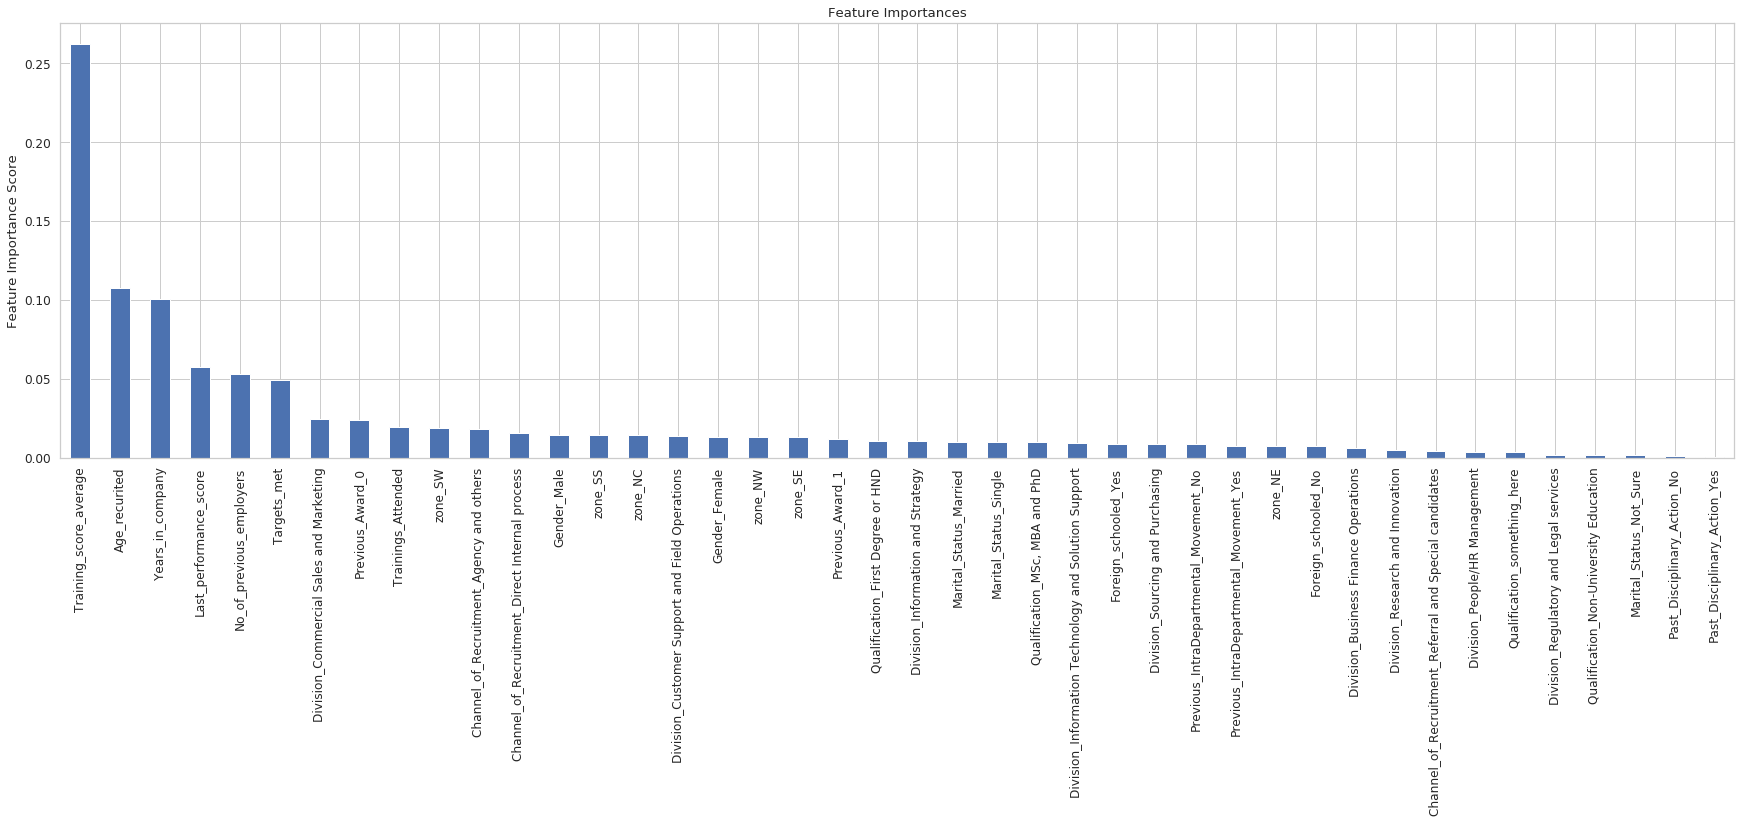

In [109]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 30, 8
feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')